In [1]:
%%capture
!pip install open3d
!pip install torchinfo

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms
import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import open3d as o3d
import plotly.graph_objects as go


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.4.0+cu121  Device: cpu


In [3]:
from google.colab import drive
drive.mount("/content/drive")

drive_path = "/content/drive/MyDrive/CV/MPI-FAUST"
training_path = drive_path + "/training"
test_path = drive_path + "/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
text_file = open(training_path+"/ground_truth_vertices/tr_gt_000.txt", "r")
lines = text_file.readlines()
print(len(lines))
vertices = []
for i in range(len(lines)):
    vertices.append(int(lines[i].rstrip('\n')))
text_file.close()

176387


In [ ]:
# Scan

cloud_mesh_scan = o3d.io.read_triangle_mesh(training_path+"/scans/tr_scan_000.ply")
np.asarray(cloud_mesh_scan.vertices)
cloud_mesh_scan.compute_vertex_normals()
cloud_mesh_scan.compute_triangle_normals()

TriangleMesh with 176387 points and 352169 triangles.

In [ ]:
# Registration

cloud_mesh_reg = o3d.io.read_point_cloud(training_path+"/registrations/tr_reg_000.ply")

In [ ]:
points_reg = np.asarray(cloud_mesh_reg.points)
colors_reg = np.asarray(cloud_mesh_reg.colors)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x = points_reg[:,0], y=points_reg[:,1], z=points_reg[:,2],
            mode = 'markers',
            marker = dict(size=0.5, color=colors_reg)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)

fig.show()

In [ ]:
vert = np.asarray(cloud_mesh_scan.vertices)
triang = np.asarray(cloud_mesh_scan.triangles)
colors_scan = np.asarray(cloud_mesh_reg.colors)
fig = go.Figure(
    data=[
        go.Mesh3d(
            x = vert[:,0], y=vert[:,1], z=vert[:,2],
            i = triang[:,0], j=triang[:,1], k=triang[:,2],
            facecolor=colors_scan,
            opacity=0.50
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)

fig.show()

In [4]:
class FAUST_Dataset(Dataset):
    """
        This class is used to load the FAUST dataset
    """

    def __init__(self, data_path, transform=None):

        self.data_path = data_path
        self.clouds = self.importData(self.data_path)

    def __getitem__(self, index):

      return torch.Tensor.numpy(self.clouds[index])

    def __len__(self):
        # num samples, num points, coordinates
        return self.clouds.size()[0]

    def importData(self, data_path, SAMPLING=True, SAMPLING_SIZE=1024):
        """
        This function is used to import the Dataset from Google Drive

        Args:
            data_path (str): path to the dataset
            SAMPLING (bool): whether to sample the Point Cloud or not
            SAMPLING_SIZE (int): number of points to sample from the complete Point Cloud

        Returns:
            torch.tensor: matrix of Point Clouds
        """

        input_mat = []
        s = 0
        directory_path = data_path + "/scans/"
        for file in os.listdir(directory_path):
            if file.endswith(".ply"):
                file_mesh = o3d.io.read_triangle_mesh(directory_path+file)
                vert = np.asarray(file_mesh.vertices)
                if SAMPLING:
                    indices = np.random.choice(len(vert), size=SAMPLING_SIZE)
                    vert = vert[indices]
                s += len(vert)
                input_mat.append(vert)

        return torch.tensor(np.array(input_mat)).to(torch.float32)

    def plotCloud(self, cloud):
        """
        This function is used to plot the Point Cloud

        Args:
            cloud (np.array): Point Cloud

        Returns:
            None
        """
        if len(cloud.shape) == 3:
            # when using DataLoader you have a shape (1, SAMPLING_SIZE, 3)
            cloud = cloud[0]

        fig = go.Figure(
            data=[
            go.Scatter3d(
                x =cloud[:,0], y=cloud[:,1], z=cloud[:,2],
                mode = 'markers',
                marker = dict(size=0.5, color=[])
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True),
                )
            )
        )
        fig.show()


trsfrmt = transforms.Compose([
            transforms.ToTensor()
        ])


trainSet = FAUST_Dataset(training_path, transform=trsfrmt) # 100 files "training/scans/tr_scan_0xy.ply"

testSet = FAUST_Dataset(test_path) # 200 files "test/scans/test_scan_xyz.ply"

# create DataLoaders

train_loader = DataLoader(dataset=trainSet, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=testSet, batch_size=1, shuffle=False)

In [ ]:
"""
    Example of what a Point Cloud looks like
"""
for cloud in train_loader:
    trainSet.plotCloud(cloud.numpy())
    break


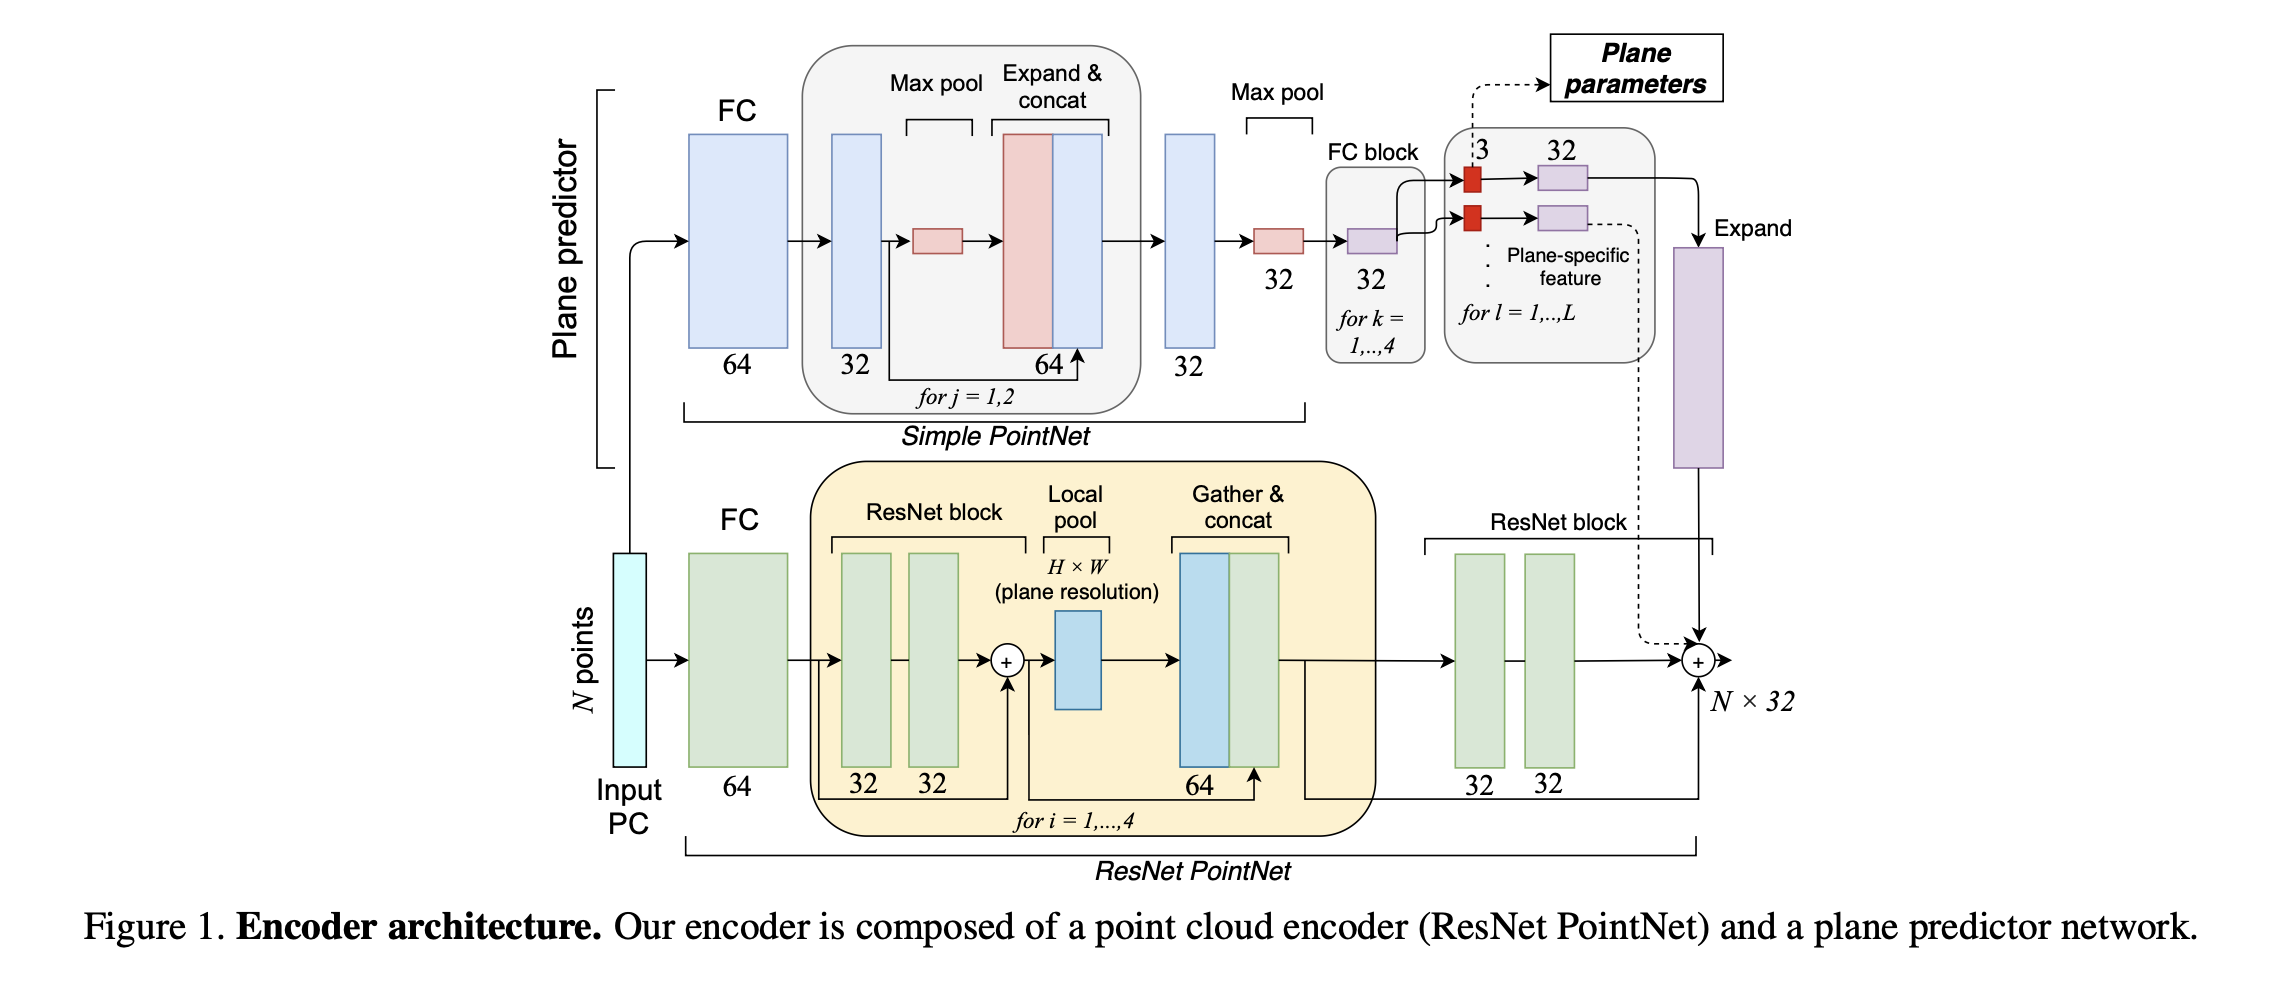

In [35]:
class ResBlock(nn.Module):
    """
        This class is used to define a Residual Block, which is one of the main component of the ResNetPointNet architecture
    """

    def __init__(self, in_dim=64, n_points=1024, h_dim=32, out_dim=64):
        super(ResBlock, self).__init__()

        self.n_points = n_points

        #> First part of the Block

        self.fc1 = nn.Linear(
            in_dim,
            h_dim
        )
        self.bn1 = nn.BatchNorm1d(self.n_points)

        #> Second part of the Block

        self.fc2 = nn.Linear(
            h_dim,
            out_dim
        )
        self.bn2 = nn.BatchNorm1d(self.n_points)

        #> Skip connection

        if in_dim != out_dim:
            # size mismatch (never happen in my case)
            self.residual = nn.Linear(in_dim, out_dim)
        else:
            # same size
            self.residual = None


    def forward(self, x):
        # Input: (b,p,in_dim) = (b,p,64)

        first_part = F.relu(self.bn1(self.fc1(x))) # (b,p,64) -> (b,p,32)

        second_part = self.bn2(self.fc2(first_part)) # (b,p,32) -> (b,p,64)

        if self.residual is None:
            # no size mismatch
            res = x # (b,p,64)
        else:
            # transformation if there is a size mismatch in_dim != out_dim
            res = self.residual(x) # (b,p,in_dim) -> (b,p,64)

        # add residual connection
        third_part = second_part + res # (b,p,64) -> (b,p,64)

        return F.relu(third_part)

In [ ]:
class ResNetPointNet(nn.Module):
    """
        This class is used to define the PointNet model used to form a feature embedding for each point in the Point Cloud given in input.
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3)

            > Fully Connected Layer (3, in_dim=64)
            > 5 Residual Blocks with Local Pooling and Concatenation
            > Fully Connected Layer

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """

    def __init__(self, in_dim=64, n_points=1024, res_dim=32, out_dim=64, n_blocks=5):
        super(ResNetPointNet, self).__init__()

        self.fc1 = nn.Linear(3, in_dim)

        self.res = nn.ModuleList([
            ResBlock(in_dim, n_points, res_dim, in_dim) for n_res in range(n_blocks)
        ])

        self.fc2 = nn.Linear(out_dim, out_dim)

    def forward(self, x):
        # Input: (batch, n_points, 3)

        # First FC Layer (batch, n_points, 3) -> (batch, n_points, in_dim=64)
        fc1 = self.fc1(x)

        print("\nFirst res block \n")
        # First ResBlock (batch, n_points, in_dim=64) -> (batch, n_points, res_dim=32)
        res = self.res[0](fc1)
        i = 1
        # 2-5 ResBlock (batch, n_points, res_dim=32) -> (batch, n_points, res_dim=32)
        #  double check this part with the image and also the size
        for res_block in self.res[1:]:
            # local max pooling
            pool = LocalPooling()
            # concatenation
            res = torch.cat((res, pool), dim=1)
            # following residual block
            print(f"\n{i} res block \n")
            res = res_block(res)
            i += 1

        # Last FC Layer (batch, n_points, res_dim=32) -> (batch, n_points, res_dim=32)
        x = self.fc2(x)

        return x

model = ResNetPointNet()
for batch in train_loader:
    pred = model(batch)
    break

In [ ]:
def LocalPooling(x):
        """
            Unlike the Vanilla PointNet, we perform Local Max Pooling on the output of each ResBlock and then we concatenate the result
            with the features before the operation.

            ResBlock ________________
                |                    |
                |                    |
            LocalPool                |
                |                    |
                v                    |
                +   <----------------'

            @ INPUT:  Tensor of shape (batch_size, num_points, 32)
            @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
        """
        return 0

In [ ]:
class PlanePredictor(nn.Module):
    """
        This class is used to define the Plane Predictor of our Architecture, which will predict the plane parameters of L dynamic planes
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent Point Clouds

            > Simple PointNet which learns the global context of the input point clouds
            > This information is encoded into one global feature by using Max Pooling
            > 4 Fully Connected Layers with hidden dimension = 32
            > L Shallow Networks with hidden dimension = 3 which will give us the Predicted Plane Parameters
            > L Fully Connected Layers with 1 layer and hidden dimension = D (same as point cloud encoder hidden dimension)
            > Each plane-specific feature is expanded to N x D to match the output of the point cloud encoder, which will be summed together


            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be processed into U-Net

    """
    def __init__(self, simplePointNet, in_dim=64, n_points=1024, res_dim=32, out_dim=64, n_fc=4, L=3):
        super(PlanePredictor, self).__init__()

        self.pointNet = simplePointNet

        # 4 FC layers with hidden dim = 32

        self.four_fc = nn.ModuleList(
            [nn.Linear(32, 32) for i in range(n_fc)]
        )

        # Plane parameters

        # L shallow networks dim = 32

        self.shallow_nets = nn.ModuleList(
            [nn.Linear(32, 3) for i in range(L)]
        )

In [ ]:
class SimplePointNet(nn.Module):
    """
        This class is used to define a simple variant of the PointNet Model, which is one of the main components of the Plane Predictor Network.
        This Network will provide us a global context of the Input Point Clouds
        Architecture Design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent the Input Point Clouds

            > Fully Connected Layer (3, 64)

              |> Fully Connected Layer (64, 32)
            2*|> Global Max Pooling
              |> Concatenation btw Pooled and unpooled features

            > Fully Connected Layer (64, 32)
            > Global Max Pooling

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be used by the rest of the Plane Predictor
    """

    def __init__(self, batch_size, in_dim=64, n_points=1024, hid_dim=32, out_dim=64):
        super(SimplePointNet, self).__init__()

        self.batch_size = batch_size
        self.n_points = n_points

        self.initial_fc = nn.Linear(in_features=3, out_features=in_dim)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.fc2 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.final_fc = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

    def forward(self, x):

        x = self.initial_fc(x) # (b,p,3) --> (b,p,64)

        x1 = self.fc1(x) # (b,p,64) --> (b,p,32)
        x1_t = x1.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x1 = self.pool(x1_t) # (b,32,p) -> (b,32,1)
        exp_pool_x1 = pool_x1.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x1 = torch.cat([x1, exp_pool_x1], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        x2 = self.fc2(concat_x1) # (b,p,64) -> (b,p,32)
        x2_t = x2.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x2 = self.pool(x2_t) # (b,32,p) -> (b,32,1)
        exp_pool_x2 = pool_x2.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x2 = torch.cat([x2, exp_pool_x2], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        pre_pool_out = self.final_fc(concat_x2) # (b,p,64) -> (b,p,32)
        pre_pool_out_t = pre_pool_out.transpose(1,2) # (b,p,32) -> (b,32,p)
        out = self.pool(pre_pool_out_t) # (b,32,p) -> (b,32,1)

        return out.transpose(1,2).expand(self.batch_size, self.n_points, 32)

In [ ]:
class UNet(nn.Module):
    """
        This class is used to define the UNet of our Architecture, which is the final part of our Encoder.
        Architecture design:

        @ INPUT: Tensor of shape (batch_size, num_points,)

        @ OUTPUT: Tensor of shape (batch_size, num_points,)
    """